In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from skimpy import skim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

C:\Users\ASUS\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
target = new_client.target
target_query = target.search('Neuraminidase')
targets = pd.DataFrame.from_dict(target_query)

In [5]:
dataframes = []

In [6]:
for i in range(len(targets)):
    target_chembl_id = targets.target_chembl_id.iloc[i]
    target_name = targets.target_chembl_id.iloc[i]
    
    activity = new_client.activity
    activity_query = activity.filter(target_chembl_id=target_chembl_id)
    
    df = pd.DataFrame.from_dict(activity_query)
    df['target'] = target_name
    
    dataframes.append(df)

In [7]:
len(dataframes)

39

In [8]:
df = pd.concat(dataframes[:40], ignore_index=True)
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,target
0,None,None,72419,[],CHEMBL808321,inhibition of Influenza A Sialidase,B,None,None,BAO_0000192,...,Neuraminidase,211044,None,None,Ki,M,UO_0000065,None,0.000004,CHEMBL2051
1,None,None,72420,[],CHEMBL808321,inhibition of Influenza A Sialidase,B,None,None,BAO_0000192,...,Neuraminidase,211044,None,None,Ki,M,UO_0000065,None,1E-9,CHEMBL2051
2,None,None,89474,[],CHEMBL808321,inhibition of Influenza A Sialidase,B,None,None,BAO_0000192,...,Neuraminidase,211044,None,None,Ki,M,UO_0000065,None,4E-8,CHEMBL2051
3,None,None,105745,[],CHEMBL882330,inhibitory concentration required to inhibit n...,B,None,None,BAO_0000190,...,Neuraminidase,211044,None,None,IC50,uM,UO_0000065,None,40.0,CHEMBL2051
4,None,None,106883,[],CHEMBL882330,inhibitory concentration required to inhibit n...,B,None,None,BAO_0000190,...,Neuraminidase,211044,None,None,IC50,uM,UO_0000065,None,0.1,CHEMBL2051


In [9]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7294   │ │ string      │ 38    │                                                          │
│ │ Number of columns │ 44     │ │ int32       │ 6     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA ┃ NA % ┃ mean     ┃ sd      ┃ p0    ┃ p25     ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ activity_id   │  0 │    0 │ 12000000 │ 7300000 │ 72000 │ 3300000 │ 15000000 │ 18000000 │ 25000000 │ ▆▁▁▃▇  │  │
│ │ document_year │  0 │    0 │     2000 │     6.2 │  2000 │    2000 │     2000 │     2000 │     2000 │ ▂▁▁▇▇▇ │  │
│ │ potential_dup │  0 │    0 │    0.066 │    0.25 │     0 │       0 │        0 │        0 │        1 │ ▇    ▁ │  │
│ │ licate        │    │      │          │         │       │         │          │          │          │        │  │
│ │ record_id     │  0 │    0 │  2000000 │ 1100000 │ 23000 │  910000 │  2100000 │  3000000 │  3900000 │ ▃▃▃▅▇▁ │  │
│ │ src_id        │  0 │    0 │      6.8 │      13 │     1 │       1 │        1 │        1 │       38 │ ▇    ▂ │  │
│ │ standard_flag │  0 │    0 │     0.88 │    0.33 │     0 │       1 │        1 │        1 │        1 │ ▁    ▇ │  │
│ └───────────────┴────┴──────┴──────────┴─────────┴───────┴─────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA       ┃ NA %       ┃ words per row           ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ activity_comment                    │     5959 │       81.7 │                    0.24 │               1717 │  │
│ │ assay_chembl_id                     │        0 │          0 │                       1 │               7294 │  │
│ │ assay_description                   │        0 │          0 │                      34 │             245391 │  │
│ │ assay_type                          │        0 │          0 │                       1 │               7294 │  │
│ │ assay_variant_accession             │     7050 │      96.65 │                   0.033 │                244 │  │
│ │ assay_variant_mutation              │     7050 │      96.65 │                   0.033 │                244 │  │
│ │ bao_endpoint                        │        0 │          0 │                       1 │               7294 │  │
│ │ bao_format                          │        0 │          0 │                       1 │               7294 │  │
│ │ bao_label                           │        0 │          0 │                     2.8 │              20479 │  │
│ │ canonical_smiles                    │        0 │          0 │                       1 │               7294 │  │
│ │ data_validity_comment               │     6311 │    

In [10]:
df = df.drop(["upper_value","toid","text_value","standard_upper_value","standard_text_value","data_validity_description",
             "data_validity_comment","molecule_pref_name","assay_variant_mutation","assay_variant_accession",
             "activity_comment","activity_properties","action_type","ligand_efficiency"],axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7294 entries, 0 to 7293
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   activity_id                7294 non-null   int64 
 1   assay_chembl_id            7294 non-null   object
 2   assay_description          7294 non-null   object
 3   assay_type                 7294 non-null   object
 4   bao_endpoint               7294 non-null   object
 5   bao_format                 7294 non-null   object
 6   bao_label                  7294 non-null   object
 7   canonical_smiles           7294 non-null   object
 8   document_chembl_id         7294 non-null   object
 9   document_journal           6123 non-null   object
 10  document_year              7294 non-null   int64 
 11  molecule_chembl_id         7294 non-null   object
 12  parent_molecule_chembl_id  7294 non-null   object
 13  pchembl_value              4450 non-null   object
 14  potentia

In [12]:
df.isnull().sum()

activity_id                     0
assay_chembl_id                 0
assay_description               0
assay_type                      0
bao_endpoint                    0
bao_format                      0
bao_label                       0
canonical_smiles                0
document_chembl_id              0
document_journal             1171
document_year                   0
molecule_chembl_id              0
parent_molecule_chembl_id       0
pchembl_value                2844
potential_duplicate             0
qudt_units                    561
record_id                       0
relation                      476
src_id                          0
standard_flag                   0
standard_relation             476
standard_type                   0
standard_units                535
standard_value                476
target_chembl_id                0
target_organism                 0
target_pref_name                0
target_tax_id                   0
type                            0
units         

<Axes: >

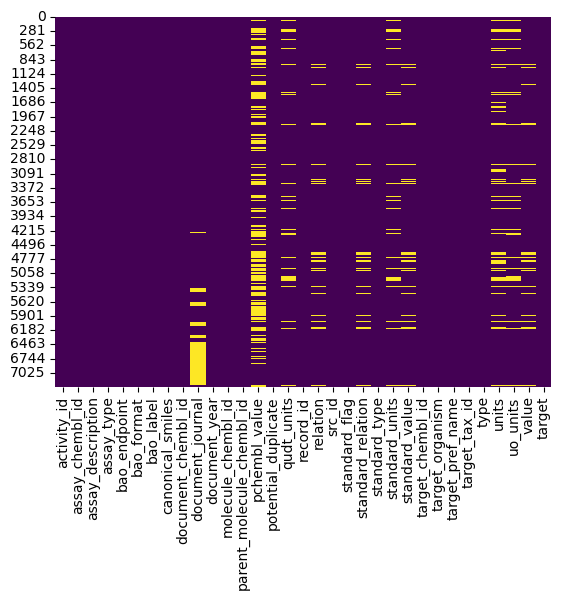

In [13]:
sns.heatmap(df.isnull(), cbar = False, cmap = 'viridis')

In [14]:
df = df.dropna()
df

,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,document_chembl_id,document_journal,...,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,type,units,uo_units,value,target
0,72419,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(O)C=C(C(=O)O)OC1[C@H](O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,4000.0,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,0.000004,CHEMBL2051
1,72420,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(NC(=N)N)C=C(C(=O)O)OC1C(O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,1.0,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,1E-9,CHEMBL2051
2,89474,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(N)C=C(C(=O)O)OC1[C@H](O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,40.0,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,4E-8,CHEMBL2051
3,105745,CHEMBL882330,inhibitory concentration required to inhibit n...,B,BAO_0000190,BAO_0000357,single protein format,CC(=O)N[C@@H]([C@H](O)[C@H](O)CO)[C@H]1OC(O)(C...,CHEMBL1133646,J Med Chem,...,40000.0,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,IC50,uM,UO_0000065,40.0,CHEMBL2051
4,106883,CHEMBL882330,inhibitory concentration required to inhibit n...,B,BAO_0000190,BAO_0000357,single protein format,CCCCC(NC(C)=O)[C@@H]1CC(C(=O)O)C[C@H]1N=C(N)N,CHEMBL1133646,J Med Chem,...,100.0,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,IC50,uM,UO_0000065,0.1,CHEMBL2051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,12100238,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,COc1c(F)c(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c...,CHEMBL2169867,J Med Chem,...,30.0,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,uM,UO_0000065,0.03,CHEMBL6115
6407,12100239,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,Cc1ccccc1[C@H](CC(=O)O)NC(=O)c1cc(OCC2CC2)n(-c...,CHEMBL2169867,J Med Chem,...,15.0,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,uM,UO_0000065,0.015,CHEMBL6115
6408,12100240,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,CCOc1cc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c1c...,CHEMBL2169867,J Med Chem,...,15.0,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,uM,UO_0000065,0.015,CHEMBL6115
6409,12100241,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,COc1cc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c1cc...,CHEMBL2169867,J Med Chem,...,26.0,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,uM,UO_0000065,0.026,CHEMBL6115


<Axes: >

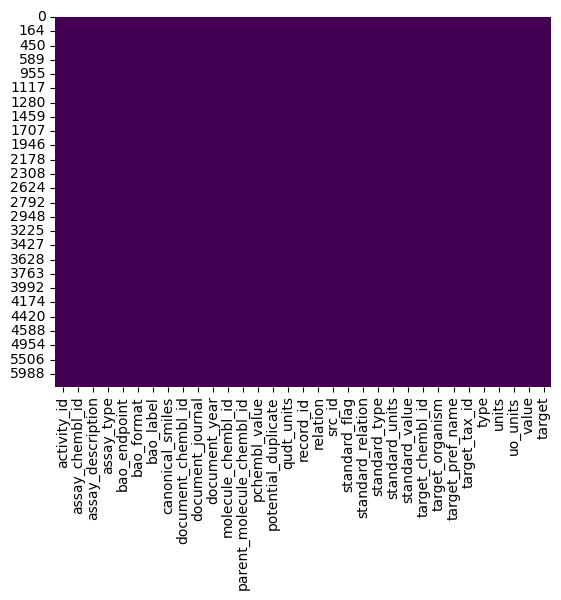

In [15]:
sns.heatmap(df.isnull(), cbar = False, cmap = 'viridis')

In [16]:
numerics = ['int16', 'int32', 'int64', 'float']
numeric_df = df.select_dtypes(include = numerics)
numeric_df

,activity_id,document_year,potential_duplicate,record_id,src_id,standard_flag
0,72419,1994,0,307604,1,1
1,72420,1994,0,307606,1,1
2,89474,1994,0,307605,1,1
3,105745,2000,0,221284,1,1
4,106883,2000,0,221285,1,1
...,...,...,...,...,...,...
6406,12100238,2012,0,1741344,1,1
6407,12100239,2012,0,1741343,1,1
6408,12100240,2012,0,1741342,1,1
6409,12100241,2012,0,1741341,1,1


<Axes: >

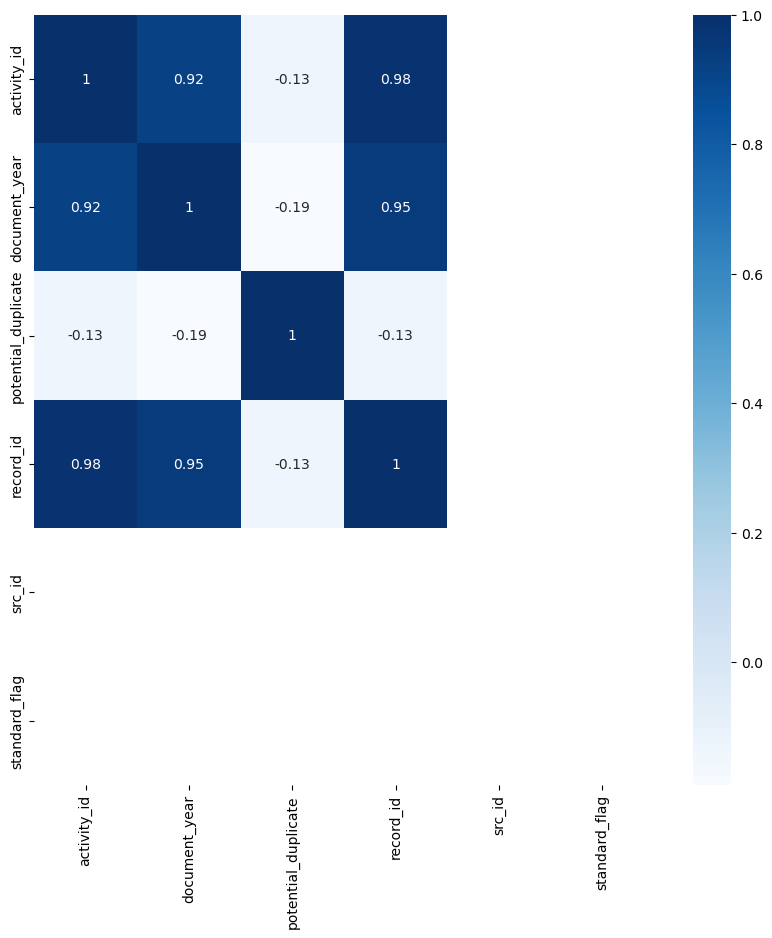

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(numeric_df.corr(), cbar = True, annot = True, cmap = 'Blues')

In [19]:
pd.unique(df['units'])


array(['M', 'uM', 'nM', 'NM', 'microM', 'umol/L', "10'-10M",
       "10'-4microM", "10'-8M", "10'-7M", "10'-6M", "10'-5M", "10'-9M",
       'mM'], dtype=object)

In [ ]:
# def convert_values(row):
#     try:
#         value = pd.to_numeric(row['value'], errors='coerce')
#         standard_value = pd.to_numeric(row['standard_value'], errors='coerce')
#     except ValueError:
#         return None, None
    
#     if row['units'] == 'uM':
#         value /= 1000000
#         standard_value /= 1000000
#     elif row['units'] == 'mM':
#         value /= 1000
#         standard_value /= 1000
    
#     return value, standard_value

# # Apply the conversion
# df[['value', 'standard_value']] = df.apply(convert_values, axis=1, result_type='expand')

# # Display the DataFrame
# df

In [ ]:
# def convert_values(row):
#     try:
#         value = pd.to_numeric(row['value'],errors='coerce')
#         standard_value = pd.to_numeric(row['standard_value'], errors = 'coerce')
#     except ValueError:
#         return None
#     if row['units'] == 'uM' or row['units'] == 'microM' or row['units'] == 'umol/L' or row['units'] == "10'-6M":
#         value /= 1000000
#         standard_value /= 1000000
#     elif (row['units'] == 'nM') or (row['units'] == 'NM') or (row['units'] == "10'-9M"):
#         value /= 1000000000
#         standard_value /= 1000000000
#     elif row['units'] ==  "10'-10M":
#         value /= 10000000000
#         standard_value /= 10000000000
#     elif row['units'] == "10'-4microM":
#         value /= 10000000000
#         standard_value /= 10000000000
#     elif row['units'] == "10'-8M":
#         value /= 100000000
#         standard_value /= 100000000
#     elif row['units'] == "10'-7M":
#         value /= 10000000
#         standard_value /= 10000000
#     elif row['units'] == "10'-5M":
#         value /= 100000
#         standard_value /= 100000
#     elif row['units'] == 'mM':
#         value /= 1000
#         standard_value /= 1000
#     else:
#         return value, standard_value
#     return value, standard_value
# df[['value','standard']] = df.apply(convert_values, axis = 1,result_type = 'expand')
# # df['units'] = 'M'
# df

In [25]:
def convert_values(row):
    try:
        value = pd.to_numeric(row['value'],errors='coerce')
    except ValueError:
        return None
    if row['units'] == 'uM' or row['units'] == 'microM' or row['units'] == 'umol/L' or row['units'] == "10'-6M":
        return value / 1000000
    elif (row['units'] == 'nM') or (row['units'] == 'NM') or (row['units'] == "10'-9M"):
        return value / 1000000000
    elif row['units'] ==  "10'-10M":
        return value / 10000000000
    elif row['units'] == "10'-4microM":
        return value / 10000000000
    elif row['units'] == "10'-8M":
        return value / 100000000
    elif row['units'] == "10'-7M":
        return value / 10000000
    elif row['units'] == "10'-5M":
        return value / 100000
    elif row['units'] == 'mM':
        return value / 1000
    else:
        return value
df['value'] = df.apply(convert_values, axis = 1)
def convert_standard_values(row):
    try:
        value = pd.to_numeric(row['standard_value'],errors='coerce')
    except ValueError:
        return None
    if row['units'] == 'uM' or row['units'] == 'microM' or row['units'] == 'umol/L' or row['units'] == "10'-6M":
        return standard_value / 1000000
    elif (row['units'] == 'nM') or (row['units'] == 'NM') or (row['units'] == "10'-9M"):
        return standard_value / 1000000000
    elif row['units'] ==  "10'-10M":
        return standard_value / 10000000000
    elif row['units'] == "10'-4microM":
        return standard_value / 10000000000
    elif row['units'] == "10'-8M":
        return standard_value / 100000000
    elif row['units'] == "10'-7M":
        return standard_value / 10000000
    elif row['units'] == "10'-5M":
        return standard_value / 100000
    elif row['units'] == 'mM':
        return standard_value / 1000
    else:
        return standard_value
df['standard_value'] = df.apply(convert_values, axis = 1)

df['units'] = 'M'
df

,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,document_chembl_id,document_journal,...,target_chembl_id,target_organism,target_pref_name,target_tax_id,type,units,uo_units,value,target,fingerprint
0,72419,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(O)C=C(C(=O)O)OC1[C@H](O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,4.000000e-06,CHEMBL2051,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
1,72420,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(NC(=N)N)C=C(C(=O)O)OC1C(O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,1.000000e-09,CHEMBL2051,"[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
2,89474,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(N)C=C(C(=O)O)OC1[C@H](O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,4.000000e-08,CHEMBL2051,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
3,105745,CHEMBL882330,inhibitory concentration required to inhibit n...,B,BAO_0000190,BAO_0000357,single protein format,CC(=O)N[C@@H]([C@H](O)[C@H](O)CO)[C@H]1OC(O)(C...,CHEMBL1133646,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,IC50,M,UO_0000065,4.000000e-11,CHEMBL2051,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ..."
4,106883,CHEMBL882330,inhibitory concentration required to inhibit n...,B,BAO_0000190,BAO_0000357,single protein format,CCCCC(NC(C)=O)[C@@H]1CC(C(=O)O)C[C@H]1N=C(N)N,CHEMBL1133646,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,IC50,M,UO_0000065,1.000000e-13,CHEMBL2051,"[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,12100238,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,COc1c(F)c(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,3.000000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, ..."
6407,12100239,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,Cc1ccccc1[C@H](CC(=O)O)NC(=O)c1cc(OCC2CC2)n(-c...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,1.500000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, ..."
6408,12100240,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,CCOc1cc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c1c...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,1.500000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, ..."
6409,12100241,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,COc1cc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c1cc...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,2.600000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, ..."


In [21]:
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.RDKFingerprint(mol)
    else:
        return None

In [22]:
df['fingerprint'] = df['canonical_smiles'].apply(smiles_to_mol)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 6411
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_id                3366 non-null   int64  
 1   assay_chembl_id            3366 non-null   object 
 2   assay_description          3366 non-null   object 
 3   assay_type                 3366 non-null   object 
 4   bao_endpoint               3366 non-null   object 
 5   bao_format                 3366 non-null   object 
 6   bao_label                  3366 non-null   object 
 7   canonical_smiles           3366 non-null   object 
 8   document_chembl_id         3366 non-null   object 
 9   document_journal           3366 non-null   object 
 10  document_year              3366 non-null   int64  
 11  molecule_chembl_id         3366 non-null   object 
 12  parent_molecule_chembl_id  3366 non-null   object 
 13  pchembl_value              3366 non-null   objec

In [26]:
df

,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,document_chembl_id,document_journal,...,target_chembl_id,target_organism,target_pref_name,target_tax_id,type,units,uo_units,value,target,fingerprint
0,72419,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(O)C=C(C(=O)O)OC1[C@H](O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,4.000000e-06,CHEMBL2051,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
1,72420,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(NC(=N)N)C=C(C(=O)O)OC1C(O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,1.000000e-09,CHEMBL2051,"[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
2,89474,CHEMBL808321,inhibition of Influenza A Sialidase,B,BAO_0000192,BAO_0000357,single protein format,CC(=O)NC1C(N)C=C(C(=O)O)OC1[C@H](O)[C@H](O)CO,CHEMBL1127812,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,Ki,M,UO_0000065,4.000000e-08,CHEMBL2051,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
3,105745,CHEMBL882330,inhibitory concentration required to inhibit n...,B,BAO_0000190,BAO_0000357,single protein format,CC(=O)N[C@@H]([C@H](O)[C@H](O)CO)[C@H]1OC(O)(C...,CHEMBL1133646,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,IC50,M,UO_0000065,4.000000e-11,CHEMBL2051,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ..."
4,106883,CHEMBL882330,inhibitory concentration required to inhibit n...,B,BAO_0000190,BAO_0000357,single protein format,CCCCC(NC(C)=O)[C@@H]1CC(C(=O)O)C[C@H]1N=C(N)N,CHEMBL1133646,J Med Chem,...,CHEMBL2051,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Neuraminidase,211044,IC50,M,UO_0000065,1.000000e-13,CHEMBL2051,"[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,12100238,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,COc1c(F)c(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,3.000000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, ..."
6407,12100239,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,Cc1ccccc1[C@H](CC(=O)O)NC(=O)c1cc(OCC2CC2)n(-c...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,1.500000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, ..."
6408,12100240,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,CCOc1cc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c1c...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,1.500000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, ..."
6409,12100241,CHEMBL2176198,Inhibition of human recombinant Myc-His10-tagg...,B,BAO_0000190,BAO_0000219,cell-based format,COc1cc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nn1-c1cc...,CHEMBL2169867,J Med Chem,...,CHEMBL6115,Homo sapiens,Lysosomal protective protein,9606,IC50,M,UO_0000065,2.600000e-14,CHEMBL6115,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, ..."
